## У нас есть задача бинарной классификации(ham, spam), подходов может быть очень много, я попробую несколько(на что хватит времени и GPU):)

Попробуем

1) возьму базовую модель из "зоопарка" и за fine tune'ю её(roberta)

2) возьму уже зафайнтюненную модель из "зоопарка"(delphia)

3) зафайнтюню зафайнтюненную модель (delphia)

4) fasttext

ну, пора начинать

# STEP 0: importing and installing

In [ ]:
!pip install evaluate
!pip install transformers
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch]
!pip install -U torch-summary

In [ ]:
%pip install --quiet accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2  bitsandbytes==0.41.2.post2

In [ ]:
!pip install fasttext

In [25]:
!pip install gensim
!pip install nltk

In [38]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset

import transformers
from transformers import TrainingArguments, Trainer
from datasets import DatasetDict, Dataset
from transformers import RobertaForSequenceClassification, AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import RobertaTokenizer

import evaluate

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil

import fasttext

import nltk
import gensim

sns.set(palette='summer')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# STEP 1: load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/train_spam.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test_spam.csv')

# STEP 2: little bit EDA

In [5]:
df_train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4070 non-null   object
dtypes: object(1)
memory usage: 31.9+ KB


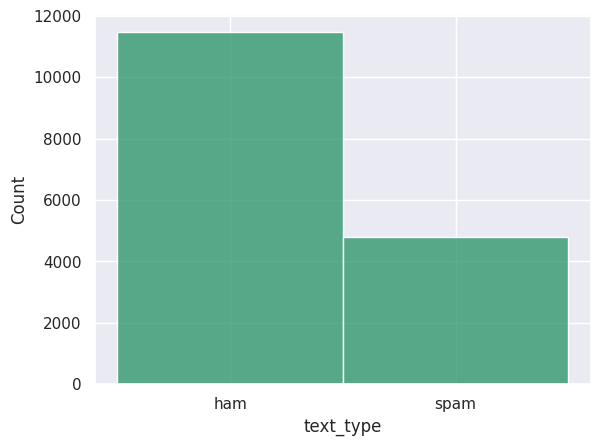

In [ ]:
sns.histplot(df_train['text_type']);

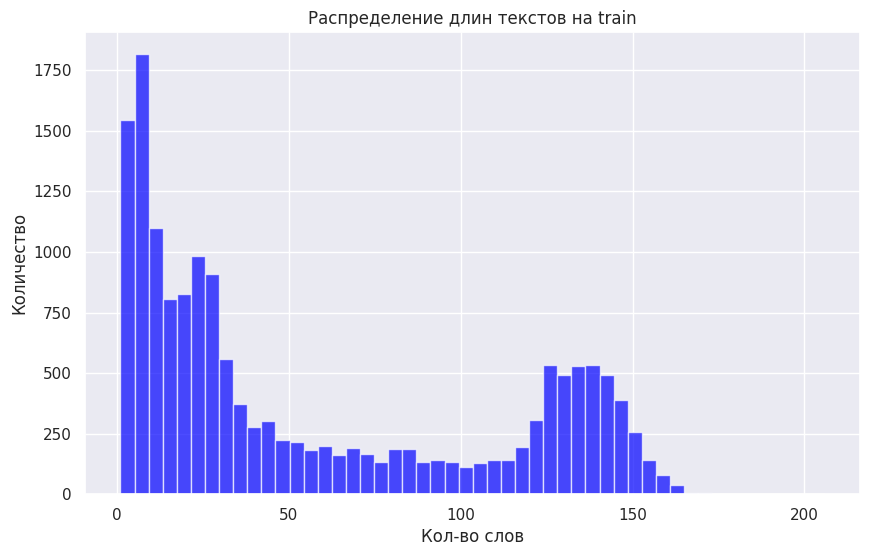

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_train['text'].apply(lambda string: len(string.split())), bins=50, color='blue', alpha=0.7)
plt.title('Распределение длин текстов на train')
plt.xlabel('Кол-во слов')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

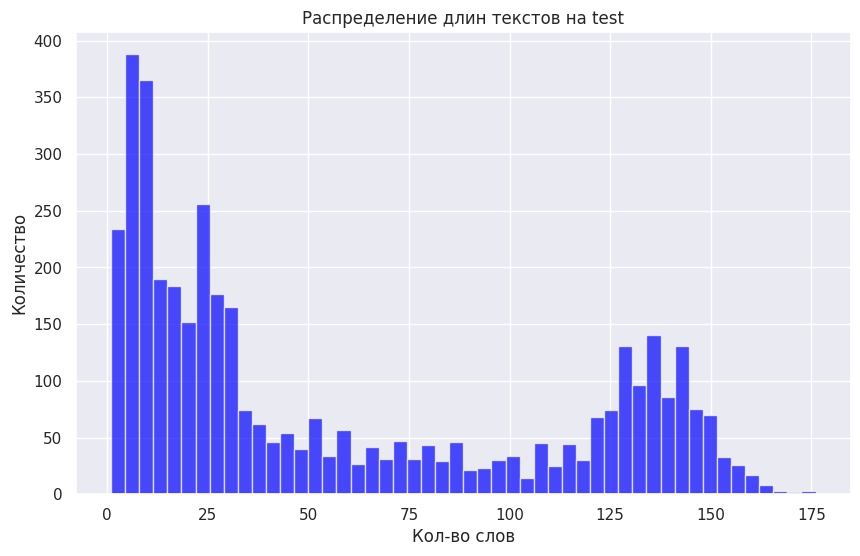

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_test['text'].apply(lambda string: len(string.split())), bins=50, color='blue', alpha=0.7)
plt.title('Распределение длин текстов на test')
plt.xlabel('Кол-во слов')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

train и test имеют одинаковое распределение длин текстов.
может тексты-спамы чаще длинее или наоборот короче ?

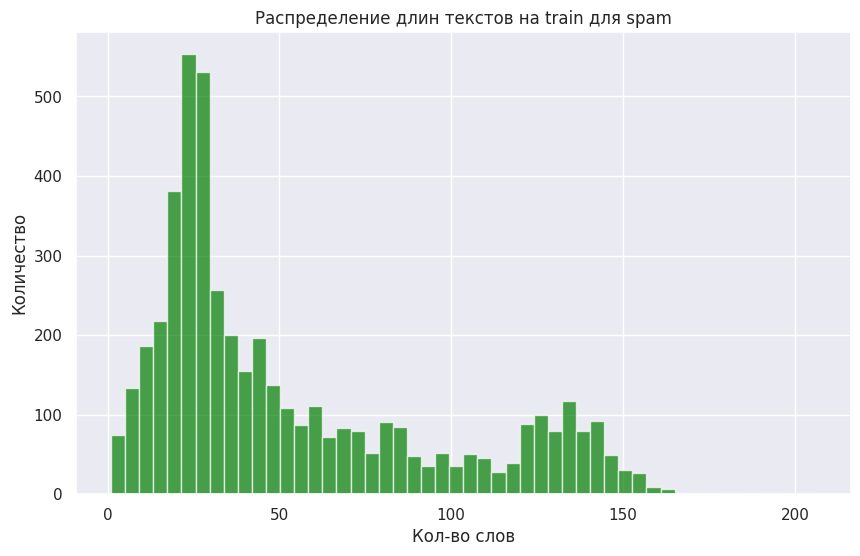

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_train[df_train['text_type'] == 'spam']['text'].apply(lambda string: len(string.split())), bins=50, color='green', alpha=0.7)
plt.title('Распределение длин текстов на train для spam')
plt.xlabel('Кол-во слов')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

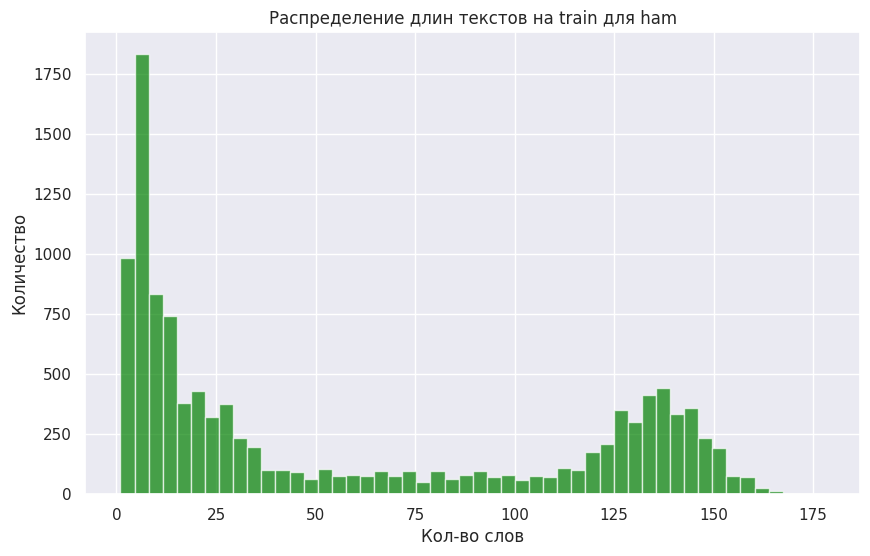

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_train[df_train['text_type'] == 'ham']['text'].apply(lambda string: len(string.split())), bins=50, color='green', alpha=0.7)
plt.title('Распределение длин текстов на train для ham')
plt.xlabel('Кол-во слов')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

хм, ну прям какие-то определенные вывод сделать сложно)

In [ ]:
print(f'Максимальная длинна в train: {np.max(df_train["text"].apply(lambda string: len(string.split())))}')
print(f'Максимальная длинна в test: {np.max(df_test["text"].apply(lambda string: len(string.split())))}')

Максимальная длинна в train: 206
Максимальная длинна в test: 176


# STEP 3: preprocessing


In [8]:
data_train_vanila = Dataset.from_pandas(df_train)
data_test_vanila = Dataset.from_pandas(df_test)

In [9]:
data = data_train_vanila.train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['text_type', 'text'],
        num_rows: 13022
    })
    test: Dataset({
        features: ['text_type', 'text'],
        num_rows: 3256
    })
})

In [12]:
label2id = {'ham': 0, 'spam': 1}
id2label = {0: 'ham', 1: 'spam'}
MAX_LENGTH = 175

def preprocess_function(examples):
  model_inputs = tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='pt',
        return_token_type_ids=False
  ).to(device)

  labels = [label2id[label] for label in examples['text_type']]
  model_inputs['labels'] = torch.tensor(labels, device=device)

  return model_inputs

In [13]:
metric = evaluate.load('roc_auc')

In [14]:
def evaluate_model(model, data_loader):
  model.eval()
  true_labels = []
  predictions = []

  with torch.no_grad():
    for batch in tqdm(data_loader):
      batch = {k: v.to(device) for k, v in batch.items()}
      input_ids = batch['input_ids']
      attention_mask = batch['attention_mask']
      labels = batch['labels']

      outputs = model(input_ids, attention_mask=attention_mask)
      logits = outputs.logits

      probs = F.softmax(logits, dim=-1)[:, 1]
      predictions.extend(probs.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())

  score = metric.compute(references=true_labels, prediction_scores=predictions)
  return score['roc_auc']

In [15]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  softmax = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
  probabilities = softmax[:, 1]
  return metric.compute(prediction_scores=probabilities, references=labels)

# STEP 4.1: modelling - roberta base
score: 0.992895685572233

In [ ]:
checkpoint = 'roberta-base'

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(checkpoint)
model_roberta = RobertaForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data_roberta = data.map(preprocess_function, batched=True, remove_columns=['text_type', 'text'])

Map:   0%|          | 0/13022 [00:00<?, ? examples/s]

Map:   0%|          | 0/3256 [00:00<?, ? examples/s]

In [ ]:
!nvidia-smi

Tue Apr 30 09:37:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0              27W /  70W |    633MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
data_roberta

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 13022
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3256
    })
})

In [ ]:
data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')

In [ ]:
train_roberta_loader = DataLoader(data_roberta['train'], shuffle=True, batch_size=8, collate_fn=data_collator)
val_roberta_loader = DataLoader(data_roberta['test'], batch_size=8, collate_fn=data_collator)

In [ ]:
BATCH_SIZE=3

args = TrainingArguments(
    output_dir='roberta_model',
    num_train_epochs=2,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    gradient_accumulation_steps=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_roberta',
    logging_steps=200,
    evaluation_strategy='steps',
    save_strategy='steps',
    eval_steps=200,
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model='roc_auc'
)

In [ ]:
trainer = Trainer(
    model=model_roberta,
    args=args,
    train_dataset=data_roberta['train'],
    eval_dataset=data_roberta['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Roc Auc
200,0.412300,0.191146,0.982152
400,0.224800,0.156562,0.985560
600,0.218800,0.304600,0.919484
800,0.224700,0.172004,0.987030
1000,0.167300,0.198844,0.989542
1200,0.127300,0.151682,0.991509
1400,0.111000,0.153343,0.986769
1600,0.100800,0.120597,0.991750
1800,0.092700,0.108085,0.992890
2000,0.086500,0.111402,0.992896


TrainOutput(global_step=2170, training_loss=0.16907982584518222, metrics={'train_runtime': 1453.2356, 'train_samples_per_second': 17.921, 'train_steps_per_second': 1.493, 'total_flos': 2341701239923500.0, 'train_loss': 0.16907982584518222, 'epoch': 1.999539276664363})

In [ ]:
trainer.state.best_model_checkpoint

'roberta_model/checkpoint-2000'

In [ ]:
model_roberta_best = RobertaForSequenceClassification.from_pretrained(trainer.state.best_model_checkpoint, num_labels=2).to(device)

In [ ]:
roc_auc_score_roberta = evaluate_model(model_roberta, val_roberta_loader)
roc_auc_score_roberta

  0%|          | 0/407 [00:00<?, ?it/s]

0.992895685572233

In [ ]:
# torch.cuda.empty_cache()

# STEP 4.2-3: modelling - delphia: spam classifier

default = 0.6206231296684653

fine_tuned = 0.9939478745058519

In [ ]:
checkpoint = "Delphia/twitter-spam-classifier"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model_delphia = AutoModelForSequenceClassification.from_pretrained(checkpoint).to(device)

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
data_delphia = data.map(preprocess_function, batched=True, remove_columns=['text_type', 'text'])

Map:   0%|          | 0/13022 [00:00<?, ? examples/s]

Map:   0%|          | 0/3256 [00:00<?, ? examples/s]

In [ ]:
train_delphia_loader = DataLoader(data_delphia['train'], shuffle=True, collate_fn=data_collator, batch_size=16)
val_delphia_loader = DataLoader(data_delphia['test'], collate_fn=data_collator, batch_size=16)

In [ ]:
evaluate_model(model_delphia, val_delphia_loader)

  0%|          | 0/204 [00:00<?, ?it/s]

0.6206231296684653

0.6206231296684653

ну если честно, я ожидал лучшего скора, но да ладно(

попробуем зафайнтюить эту модель

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
BATCH_SIZE=3

args = TrainingArguments(
    output_dir='delphi_model',
    num_train_epochs=2,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    gradient_accumulation_steps=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=200,
    evaluation_strategy='steps',
    save_strategy='steps',
    eval_steps=200,
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model='roc_auc'
)

In [ ]:
trainer = Trainer(
    model=model_delphia,
    args=args,
    train_dataset=data_delphia['train'],
    eval_dataset=data_delphia['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Roc Auc
200,0.280600,0.147770,0.984618
400,0.191500,0.142244,0.988207
600,0.197300,0.194723,0.988499
800,0.165300,0.104467,0.992326
1000,0.129500,0.158025,0.993348
1200,0.087300,0.142213,0.991835
1400,0.060000,0.141527,0.990997
1600,0.059900,0.130340,0.993290
1800,0.059500,0.113942,0.993928
2000,0.054400,0.102149,0.993948


TrainOutput(global_step=2170, training_loss=0.12293794122159755, metrics={'train_runtime': 1391.6158, 'train_samples_per_second': 18.715, 'train_steps_per_second': 1.559, 'total_flos': 2341701239923500.0, 'train_loss': 0.12293794122159755, 'epoch': 1.999539276664363})

In [ ]:
trainer.state.best_model_checkpoint

'delphi_model/checkpoint-2000'

In [ ]:
best_model_delphia = AutoModelForSequenceClassification.from_pretrained(trainer.state.best_model_checkpoint).to(device)

In [ ]:
evaluate_model(best_model_delphia, val_delphia_loader)

  0%|          | 0/204 [00:00<?, ?it/s]

0.9939478745058519

0.9939478745058519

ахахахах, ну тут явно получше))))))

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.10214945673942566, 'eval_roc_auc': 0.9939478745058519, 'eval_runtime': 37.2692, 'eval_samples_per_second': 87.364, 'eval_steps_per_second': 14.57, 'epoch': 1.999539276664363}


In [ ]:
torch.cuda.empty_cache()

сохраняю модель на всякий случай

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks'

src_path = f'/content/delphi_model/checkpoint-2000'
dst_path = f'/content/drive/MyDrive/Colab Notebooks/checkpoint-2000/'
shutil.copytree(src_path, dst_path)

'/content/drive/MyDrive/Colab Notebooks/checkpoint-2000/'

In [ ]:
files = os.listdir(dst_path)
print(files)

['model.safetensors', 'special_tokens_map.json', 'scheduler.pt', 'tokenizer.json', 'vocab.txt', 'rng_state.pth', 'training_args.bin', 'optimizer.pt', 'config.json', 'trainer_state.json', 'tokenizer_config.json']


# STEP 4.4: fasttext

score: 0.6706739832467254

In [19]:
df_train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [20]:
df_ft_train = df_train.copy()

In [22]:
df_ft_train['text_type'] = '__label__' + df_ft_train['text_type'].astype(str)

In [27]:
df_ft_train['content'] = df_ft_train['text_type'] + ' ' + df_ft_train['text']

In [28]:
df_ft_train.head()

,text_type,text,content
0,__label__ham,make sure alex knows his birthday is over in f...,__label__ham make sure alex knows his birthday...
1,__label__ham,a resume for john lavorato thanks vince i will...,__label__ham a resume for john lavorato thanks...
2,__label__spam,plzz visit my website moviesgodml to get all m...,__label__spam plzz visit my website moviesgodm...
3,__label__spam,urgent your mobile number has been awarded wit...,__label__spam urgent your mobile number has be...
4,__label__ham,overview of hr associates analyst project per ...,__label__ham overview of hr associates analyst...


In [29]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

def prep_ft(string: str) -> str:
    string = str(string)
    return ' '.join(tokenizer.tokenize(string)).lower()

In [33]:
df_ft_train['content'] = df_ft_train['content'].apply(prep_ft)

In [36]:
df_ft_train['content'].head()

0    __label__ham make sure alex knows his birthday...
1    __label__ham a resume for john lavorato thanks...
2    __label__spam plzz visit my website moviesgodm...
3    __label__spam urgent your mobile number has be...
4    __label__ham overview of hr associates analyst...
Name: content, dtype: object

In [39]:
train_tf, test_tf = train_test_split(df_ft_train, test_size=0.2)

In [43]:
train_tf.to_csv('ft_train', columns=['content'], index=False, header=False)
test_tf.to_csv('ft_test', columns=['content'], index=False, header=False)

In [44]:
model_ft = fasttext.train_supervised(input='/content/ft_train')
model_ft.test('/content/ft_test')

(3256, 0.952088452088452, 0.952088452088452)

In [47]:
y_true = test_tf['content'].apply(lambda x: 1 if '__label__spam' in x else 0)

predictions = []
confidences = []

with open('/content/ft_test', 'r') as file:
    for line in file:
        pred, confidence = model_ft.predict(line.strip(), k=1)
        predictions.append(pred[0][0])
        confidences.append(confidence[0])

y_pred = [conf if pred == '__label__spam' else 1 - conf for pred, conf in zip(predictions, confidences)]

roc_auc = roc_auc_score(y_true, y_pred)
print('ROC AUC Score:', roc_auc)

ROC AUC Score: 0.6706739832467254


 0.6706739832467254, маловато но для простой модели оч хорошо(учитывая presion и recall сверху)

# STEP 5: load data and conlusion

Вывод: судя по показателям roc_auc, лучше всего с данным датасетом будет рабоать модель дважды зафайнтюненная модель delphia(step 4.2). Она с небольшим отрывом побеждает robert'у(из step 4.1)

Мысли: у меня была идея ещё попробовать ламу, но там нужно было запариваться с выводом скора, к тому же gpu на исходе, ну и там отличия будут не сильные по идее, если здесь уже скор почти 0.993. Поэтому я забил.



ну ладно, загрузим модель и выложим данные)

In [48]:
checkpoint = '/content/drive/MyDrive/checkpoint-2000'

In [49]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint).to(device)

In [51]:
df_test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [63]:
df_ans = df_test.copy()

In [64]:
def get_prediction(text):
  inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='pt',
        return_token_type_ids=False
  )
  inputs = {key: value.to(device) for key, value in inputs.items()}

  with torch.no_grad():
    outputs = model(**inputs)
  return outputs.logits.softmax(dim=-1).cpu().numpy()[0][1]

df_ans['score'] = df_ans['text'].apply(lambda x: get_prediction(x))

In [70]:
df_ans = df_ans[['score', 'text']]

In [71]:
df_ans.head()

,score,text
0,0.000032,j jim whitehead ejw cse ucsc edu writes j you ...
1,0.002167,original message from bitbitch magnesium net p...
2,0.000020,java for managers vince durasoft who just taug...
3,0.001281,there is a youtuber name saiman says
4,0.998510,underpriced issue with high return on equity t...


In [73]:
df_ans.to_csv('vk_testovoe_scores.csv', index=False)